In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import maxwell

import os, sys, inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 

import algorithms as a
import force_functions as f

In [2]:
t_max = 100
dt = .002
N = 64
lam = 0.1931833275037836

In [3]:
def init(N, L, lattice_constant):
    
    positions = list(np.arange(-L/2., L/2., lattice_constant))
    r0 = np.array(np.meshgrid(positions, positions, positions)).T.reshape(-1,3)
    p0 = maxwell.rvs(loc=0, scale=1.5, size=(N,3)) / np.sqrt(1.5)
    
    return r0, p0

In [4]:
r0, p0 = init(N=64, L=6., lattice_constant=1.5)

In [5]:
R, P, t = a.BABAB_Ndim(r0, p0, t_max, dt, f.LJ_force, lam, thermal_noise=False,
                       periodic={'PBC': True, 'box_size': 6., 'closed': False})

  0%|          | 0/49999 [00:00<?, ?it/s]/Users/erichter/Documents/Uni/SS21/MolecularSimulations/Assignments/molecular_simulations/force_functions.py:140: RuntimeWarning: divide by zero encountered in true_divide
  f = (48 * np.power(sigma, 12) / np.power(distances, 13) - 24 * np.power(sigma, 6) / np.power(distances, 7)) / distances
/Users/erichter/Documents/Uni/SS21/MolecularSimulations/Assignments/molecular_simulations/force_functions.py:140: RuntimeWarning: invalid value encountered in subtract
  f = (48 * np.power(sigma, 12) / np.power(distances, 13) - 24 * np.power(sigma, 6) / np.power(distances, 7)) / distances
100%|██████████| 49999/49999 [01:27<00:00, 569.97it/s]


In [6]:
E = np.zeros(len(t))
for i in tqdm(range(len(t))):
    E[i] = f.calc_LJ_energy(R[i], P[i], sigma=1, periodic={'PBC': True, 'box_size': 6.})

  0%|          | 0/50000 [00:00<?, ?it/s]/Users/erichter/Documents/Uni/SS21/MolecularSimulations/Assignments/molecular_simulations/force_functions.py:216: RuntimeWarning: divide by zero encountered in true_divide
  V = (4 * np.power(sigma / distances, 12) - 4 * np.power(sigma / distances, 6))
/Users/erichter/Documents/Uni/SS21/MolecularSimulations/Assignments/molecular_simulations/force_functions.py:216: RuntimeWarning: invalid value encountered in subtract
  V = (4 * np.power(sigma / distances, 12) - 4 * np.power(sigma / distances, 6))
100%|██████████| 50000/50000 [00:25<00:00, 1927.56it/s]


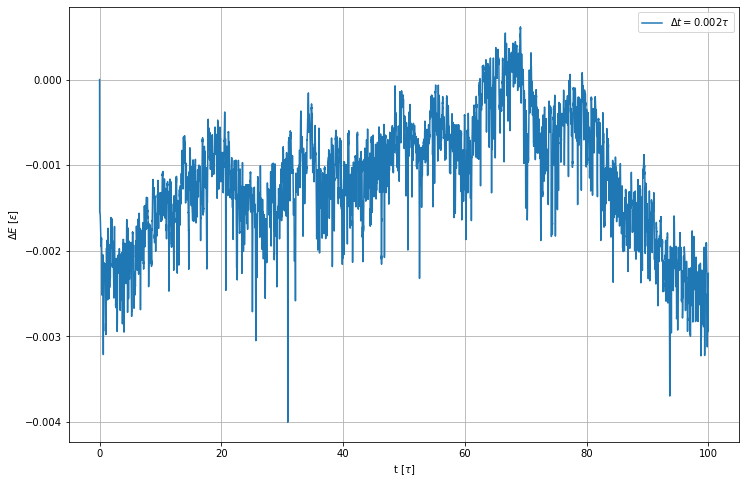

In [7]:
fig1, ax1 = plt.subplots(figsize=(12,8))
ax1.plot(t, E-E[0], label=r'$\Delta t=0.002\tau$')
ax1.set_xlabel(r't $[\tau]$')
ax1.set_ylabel(r'$\Delta E$ $[\epsilon]$')
ax1.legend()
ax1.grid(True)
plt.show()

In [8]:
R_equ = R[np.where(t>20)]

In [9]:
def Widom_method(R_equ, num_configs, k):
    
    mu_exc_mean = np.zeros(k) 
    mu_exc_std = np.zeros(k)
    
    # use different k for different numbers of test particles: M=10**k
    for j in range(1, k+1):
        mu_exc = np.zeros(num_configs)
        
        # calculating the excess for different configurations
        for i in range(num_configs):
            
            # random equlibrium sample
            r = R_equ[np.random.randint(low=0, high=len(R_equ))]
            
            # generating candidates for insertion
            r_insert = np.random.uniform(low=-3., high=3., size=(10**j, 3))
            r_old = r
            
            # random threshold for accepting particle
            u = np.random.uniform()
            
            # loop over the canditates to test if the new configuration gets accepted
            for r_insert_i in r_insert:
                
                # new configuration
                r_new = np.concatenate([r_old, np.expand_dims(r_insert_i, axis=0)])
                
                # calculating the energy difference
                DeltaE = f.calc_LJ_pot(r_new, sigma=1, periodic={'PBC': True, 'box_size': 6.}) - \
                         f.calc_LJ_pot(r_old, sigma=1, periodic={'PBC': True, 'box_size': 6.})
                
                # checking if energy difference is below threshold and if so accepting new configuration
                if DeltaE < u:
                    r_old = r_new
                else:
                    r_old = r_old
            
            # calculating the excess chemical potential
            DeltaE_exc = f.calc_LJ_pot(r_old, sigma=1, periodic={'PBC': True, 'box_size': 6.}) - \
                         f.calc_LJ_pot(r, sigma=1, periodic={'PBC': True, 'box_size': 6.})
            
            mu_exc[i] = -1.5 * np.log(np.exp(-DeltaE_exc/1.5))
        
        mu_exc_mean[j-1] = mu_exc.mean()
        mu_exc_std[j-1] = mu_exc.std()
        
    return mu_exc_mean, mu_exc_std

In [ ]:
mu_exc_mean, mu_exc_std = Widom_method(R_equ, num_configs=100, k=4)

/Users/erichter/Documents/Uni/SS21/MolecularSimulations/Assignments/molecular_simulations/force_functions.py:240: RuntimeWarning: divide by zero encountered in true_divide
  V = (4 * np.power(sigma / distances, 12) - 4 * np.power(sigma / distances, 6))
/Users/erichter/Documents/Uni/SS21/MolecularSimulations/Assignments/molecular_simulations/force_functions.py:240: RuntimeWarning: invalid value encountered in subtract
  V = (4 * np.power(sigma / distances, 12) - 4 * np.power(sigma / distances, 6))


In [ ]:
mu_exc_mean